## K-means Clustering of Stock OHLC data

### Prathish Murugan

### Refer goodnotes section for detailed observations

### This is the 2nd part, for first refer [Simulated_data_kmeans.ipynb](http://localhost:8888/notebooks/Simulated_data_kmeans.ipynb)


K-Means Clustering will be used on daily Open-High-Low-Close (OHLC) data, also known as bars or candles. Such analysis is interesting because it considers extra dimensions to daily data that are often ignored, in favor of adjusting closing prices.

Each of the High, Low, and Close dimensions will be normalized by the corresponding Open price. So the number of dimentions will be reduced from 4 to 3. By normalising each candle in this manner, the dimensionality is reduced from four (Open, High, Low, Close) to three (High/Open, Low/Open, Close/Open).

#### Data: 2 years of S&P 500


In [2]:
import copy      #to make deep copies of DataFrames
import datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mplfinance.original_flavor import candlestick_ohlc      #This is a change as mpl_finance is depricated
import matplotlib.dates as mdates
from matplotlib.dates import (
    DateFormatter, WeekdayLocator, DayLocator, MONDAY
)
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import yfinance as yf

import pandas_datareader.data as web   # Refer to this video on how to use   PDR https://www.youtube.com/watch?v=t_vZDyQDUkk

#


#### Function 1 : get_open_normalised_prices()

To get the ticker symbol, it will fetch the tickers data from Yahoo.

Then it will normalise from OHLC to H/O, L/O, C/O. Then it drops other colums and returns the dataframe.

In [3]:
def get_open_normalised_prices(symbol,start,end):
    """
    Obtains a pandas DataFrame containing open normalised prices
    for high, low and close for a particular equities symbol
    from Yahoo Finance. That is, it creates High/Open, Low/Open 
    and Close/Open columns.
    """

    yf.pdr_override() #web.DataReader() wasnt working so I installed Yfinance
    #https://stackoverflow.com/questions/74912452/typeerror-string-indices-must-be-integer-pandas-datareader
    
    df = web.get_data_yahoo(symbol, start, end) #format is web.DataReader('GE', 'yahoo', start='2019-09-10', end='2019-09-10')

    #Normalize based on Open
    df["H/O"] = df["High"]/df["Open"]
    df["L/O"] = df["Low"]/df["Open"]
    df["C/O"] = df["Close"]/df["Open"]

    #Drop other than these 3 columns
    df.drop(
        [
            "Open", "High", "Low", 
            "Close", "Volume", "Adj Close"
        ], 
        axis=1, inplace=True
    )
    
    return df
    

In [4]:
#TESTING
yf.pdr_override() 
symbol = 'AAPL'
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2015, 12, 31)
df1 = web.get_data_yahoo(symbol, start='2022-10-24', end='2022-12-23')
df2 = get_open_normalised_prices(symbol,start,end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
#TESTING
df2

,H/O,L/O,C/O
Date,,,
2013-01-02,1.002131,0.977989,0.991351
2013-01-03,1.003267,0.987443,0.989450
2013-01-04,1.003091,0.979254,0.981433
2013-01-07,1.013985,0.986973,1.003640
2013-01-08,1.005064,0.984959,0.992631
...,...,...,...
2015-12-23,1.014729,0.999347,1.012492
2015-12-24,1.000000,0.990367,0.991101
2015-12-28,1.000930,0.986895,0.992843


<Axes: xlabel='Date'>

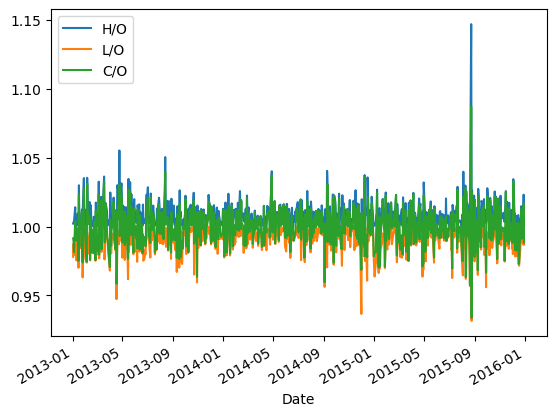

In [6]:
#TESTING
df2.plot()

#



#### Function 2 : plot_candlesticks()


"The following function plot_candlesticks makes use of the Matplotlib candlestick_ohlc method to create a financial candlestick chart of the provided price series."

But since the candlestick_ohlc did not work, I used mplfinance.original_flavor import candlestick_ohlc

"The majority of the function involves specific Matplotlib formatting to achieve correct data formatting. The comments explain each setting in more depth"

In [7]:
def plot_candlesticks(data, since):
    """
    Plot a candlestick chart of the prices,
    appropriately formatted for dates
    """
    df = copy.deepcopy(data)       #Take a deep copy of the data
    df = df[df.index >= since]     #Subset only from the 'since' date

    #When we reset the index, the old index is added as a column, and a new sequential index is used. 
    #That is from index as dates, it will make dates as a new col and keeps index as 0,1,2....
    df.reset_index(inplace=True)


    #Convert datetime objects to Matplotlib dates. 
    #It basically calculates the number of days from a set epoch, here the default is (default: '1970-01-01T00:00:00').
    #So '1970-01-02' will have value 1 and  '1970-01-10' will have value 9. 
    #So '2013-01-02' has a value of 15707.0
    df['date_fmt'] = df['Date'].apply(
        lambda date: mdates.date2num(date.to_pydatetime())       
    )


    # Visualization stuff
    #This code snippet configures the x-axis of a Matplotlib plot to display date values with major tick marks on Mondays
    #and minor tick marks on every day. It also formats the major tick labels to show abbreviated month names and day numbers.
    # Set the axis formatting correctly for dates
    # with Mondays highlighted as a "major" tick
    mondays = WeekdayLocator(MONDAY)
    alldays = DayLocator()
    weekFormatter = DateFormatter('%b %d')
    fig, ax = plt.subplots(figsize=(16,4))
    fig.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weekFormatter)

    # Plot the candlestick OHLC chart using black for
    # up days and red for down days
    csticks = candlestick_ohlc(
        ax, df[
            ['date_fmt', 'Open', 'High', 'Low', 'Close']
        ].values, width=0.6, 
        colorup='#000000', colordown='#ff0000'
    )
    ax.set_facecolor((1,1,0.9))                    #Changed set_axis_bgcolor with set_facecolor
    ax.xaxis_date()
    plt.setp(
        plt.gca().get_xticklabels(), 
        rotation=45, horizontalalignment='right'
    )
    plt.show()

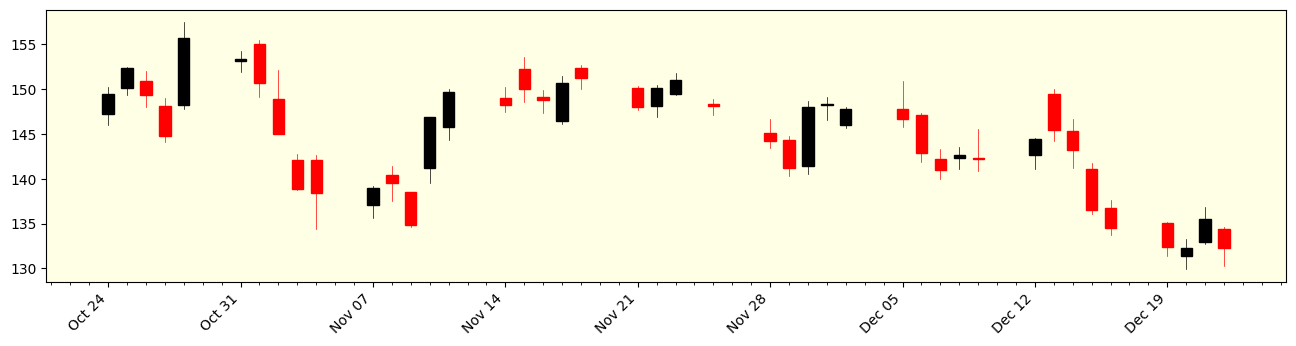

In [8]:
#TESTING
plot_candlesticks(df1, datetime.datetime(2013, 1, 1))

#



#### Function 3 : plot_3d_normalised_candles()


The following function plot_3d_normalised_candles makes a scatter plot in three-dimensional space of all of the candles, normalised by the open price. Each daily candle bar is coloured according to cluster membership (which is determined in subsequent code snippets below):

In [22]:
def plot_3d_normalised_candles(data):
    """
    Plot a 3D scatterchart of the open-normalised bars
    highlighting the separate clusters by colour
    """
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d',elev=21, azim=-135)   #If you put  elev=90, azim=-90, you can see it in 2d
    #This works ==> you do this in order to alert Matplotlib that we're using 3d data.
    # ax = Axes3D(fig, elev=21, azim=-136)   #This doesn't work
    np.float = float
    ax.scatter(
        data["H/O"], data["L/O"], data["C/O"], 
        c=labels.astype(np.float)
    )
    #ax.set_xlim([1, 1.04])
    ax.set_xlabel('High/Open')
    ax.set_ylabel('Low/Open')
    ax.set_zlabel('Close/Open')
    plt.show()

#



#### Function 3 : plot_cluster_ordered_candles(data)

Function plot_cluster_ordered_candles is similar to the above candlestick plot, except that it is now ordered by cluster membership, rather than date. In addition each cluster boundary is visualised with a blue dotted line. The function is somewhat complex, but once again this is mainly due to formatting issues with Matplotlib.

The latter section of the function involves creating a separate DataFrame called change_indices. Its job is to determine the index at which a new cluster boundary is located. This is done by sorting all elements by their cluster index and then using the diff method to obtain the change points. This is then filtered by all values that do not equal zero, which returns a DataFrame consisting of five rows, one for each boundary. This is then used by the Matplotlib axvline method to plot the dotted blue line:

In [10]:
def plot_cluster_ordered_candles(data):
    """
    Plot a candlestick chart ordered by cluster membership
    with the dotted blue line representing each cluster
    boundary.
    """
    # Set the format for the axis to account for dates
    # correctly, particularly Monday as a major tick
    mondays = WeekdayLocator(MONDAY)
    alldays = DayLocator()
    weekFormatter = DateFormatter("")
    fig, ax = plt.subplots(figsize=(16,4))
    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weekFormatter)


    # Sort the data by the cluster values and obtain
    # a separate DataFrame listing the index values at
    # which the cluster boundaries change
    df = copy.deepcopy(data)
    df.sort_values(by="Cluster", inplace=True)
    df.reset_index(inplace=True)
    df["clust_index"] = df.index
    df["clust_change"] = df["Cluster"].diff()
    change_indices = df[df["clust_change"] != 0]             #This change indices is the blue colour dotted lines in the plot

    # Plot the OHLC chart with cluster-ordered "candles"
    csticks = candlestick_ohlc(
        ax, df[
            ["clust_index", 'Open', 'High', 'Low', 'Close']
        ].values, width=0.6, 
        colorup='#000000', colordown='#ff0000'
    )
    ax.set_facecolor((1,1,0.9)) #Changed from ax.set_axis_bgcolor((1,1,0.9))

    # Add each of the cluster boundaries as a blue dotted line
    for row in change_indices.iterrows():
        plt.axvline(
            row[1]["clust_index"], 
            linestyle="dashed", c="blue"
        )
    plt.xlim(0, len(df))
    plt.setp(
        plt.gca().get_xticklabels(), 
        rotation=45, horizontalalignment='right'
    )
    plt.show()

#



#### Function 4 : create_follow_cluster_matrix(data)

Function create_follow_cluster_matrix. Its job is to produce a 
matrix, where is the number of selected clusters in the K-Means Clustering process

Each element of the matrix represents the percentage frequency of cluster 
 being the daily follow-on cluster to cluster 
. This is useful in quantitative trading setting as it allows us to determine the sample distribution of cluster changes.

In [11]:
def create_follow_cluster_matrix(data):
    """
    Creates a k x k matrix, where k is the number of clusters
    that shows when cluster j follows cluster i.
    """
    
    data["ClusterTomorrow"] = data["Cluster"].shift(-1)
    #Refer this for .shift()             https://www.geeksforgeeks.org/python-pandas-dataframe-shift/

    data.dropna(inplace=True)        #So the NANs in the below most row will be dropped, ie the last row will be dropped
    data["ClusterTomorrow"] = data["ClusterTomorrow"].apply(int)   #Convert Floats to Integers 

    #The zip() function in Python is commonly used to combine two or more iterables, such as lists, tuples, or strings, 
    #into a single iterable where elements from corresponding positions are paired together.
    sp500["ClusterMatrix"] = list(zip(data["Cluster"], data["ClusterTomorrow"])) 

    cmvc = data["ClusterMatrix"].value_counts() #return a Series containing counts of unique values.
    clust_mat = np.zeros( (k, k) )              #Creates empty square matrix named clust_mat with dimensions k by k


    #The value counts will return an iterable in "cmvc". In that iterable, we iterate row by row. For ex,
    # cluster     count
    #   1           42
    #   3           23
    #   2           14

    #Now for each row, we take the count col, ie row[1], then we see the % share of that cluster in the data
    for row in cmvc.items():            #iteritems(): was deprecated
        clust_mat[row[0]] = row[1]*100.0/len(data)
        
    return clust_mat

In [12]:
#Testing
a = [1,2,3]
b = ["as","bs","cs"]

k = list(zip(a,b))
k
#So the above function will have the cluster i and the tomorrow's cluster j in a tuple in a list

[(1, 'as'), (2, 'bs'), (3, 'cs')]

#
#


## Main Function 
####
The __main__ function ties all of the above functions together. It carries out the K-Means algorithm and uses these cluster membership values in all subsequent functions:

In [13]:
if __name__ == "__main__":
    # Obtain S&P500 pricing data from Yahoo Finance
    start = datetime.datetime(2013, 1, 1)
    end = datetime.datetime(2015, 12, 31)
    symbol = "^GSPC"
    #S&P 500 (^GSPC) SNP - SNP Real Time Price. Currency in USD
    sp500  = web.get_data_yahoo(symbol,start, end)

[*********************100%***********************]  1 of 1 completed


In [14]:
sp500 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,1462.420044,4202600000
2013-01-03,1462.420044,1465.469971,1455.530029,1459.369995,1459.369995,3829730000
2013-01-04,1459.369995,1467.939941,1458.989990,1466.469971,1466.469971,3424290000
2013-01-07,1466.469971,1466.469971,1456.619995,1461.890015,1461.890015,3304970000
2013-01-08,1461.890015,1461.890015,1451.640015,1457.150024,1457.150024,3601600000
...,...,...,...,...,...,...
2015-12-23,2042.199951,2064.729980,2042.199951,2064.290039,2064.290039,3484090000
2015-12-24,2063.520020,2067.360107,2058.729980,2060.989990,2060.989990,1411860000
2015-12-28,2057.770020,2057.770020,2044.199951,2056.500000,2056.500000,2492510000


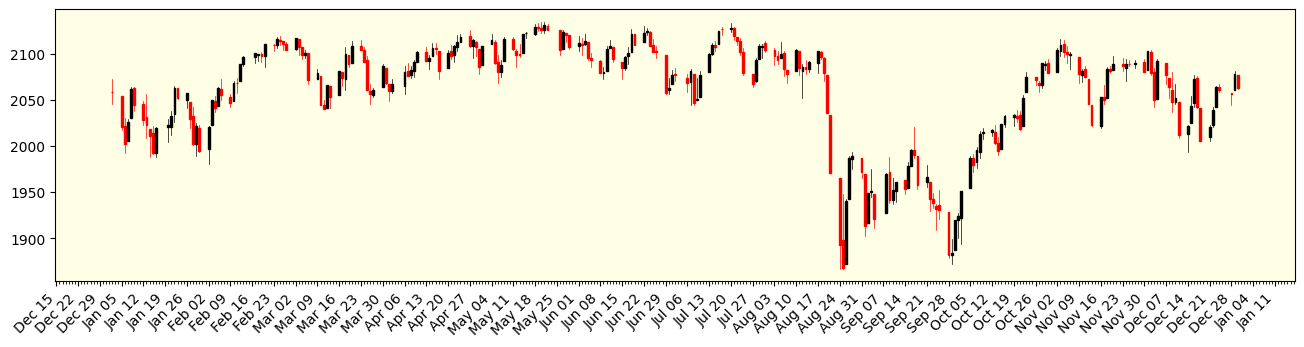

In [15]:
# Plot last year of price "candles"
if __name__ == "__main__":
    plot_candlesticks(sp500, datetime.datetime(2015, 1, 1))

In [16]:
# Get the normalised data
if __name__ == "__main__":
    sp500_norm = get_open_normalised_prices(symbol, start, end)
    

[*********************100%***********************]  1 of 1 completed


In [17]:
sp500_norm

,H/O,L/O,C/O
Date,,,
2013-01-02,1.025410,1.000000,1.025403
2013-01-03,1.002086,0.995289,0.997914
2013-01-04,1.005872,0.999740,1.004865
2013-01-07,1.000000,0.993283,0.996877
2013-01-08,1.000000,0.992989,0.996758
...,...,...,...
2015-12-23,1.011032,1.000000,1.010817
2015-12-24,1.001861,0.997679,0.998774
2015-12-28,1.000000,0.993405,0.999383


In [18]:
# Carry out K-Means clustering with five clusters on the three-dimensional data H/O, L/O and C/O
if __name__ == "__main__":
    k =5
    km = KMeans(n_clusters=k, random_state=42) #Random state is just an identity that python gives to your algo
    #Watch this  https://www.youtube.com/watch?v=rArvRWyH5Sk
    km.fit(sp500_norm)
    #You fit with sp500_norm norm data, but put the resulting labels into sp500 df for readability
    
    #Labels of each point
    labels = km.labels_
    sp500["Cluster"] = labels

/Users/pratishmurugan/miniforge3/envs/OHLCkmeans/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [19]:
sp500

,Open,High,Low,Close,Adj Close,Volume,Cluster
Date,,,,,,,
2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,1462.420044,4202600000,4
2013-01-03,1462.420044,1465.469971,1455.530029,1459.369995,1459.369995,3829730000,2
2013-01-04,1459.369995,1467.939941,1458.989990,1466.469971,1466.469971,3424290000,0
2013-01-07,1466.469971,1466.469971,1456.619995,1461.890015,1461.890015,3304970000,2
2013-01-08,1461.890015,1461.890015,1451.640015,1457.150024,1457.150024,3601600000,2
...,...,...,...,...,...,...,...
2015-12-23,2042.199951,2064.729980,2042.199951,2064.290039,2064.290039,3484090000,4
2015-12-24,2063.520020,2067.360107,2058.729980,2060.989990,2060.989990,1411860000,2
2015-12-28,2057.770020,2057.770020,2044.199951,2056.500000,2056.500000,2492510000,2


### Visualization part

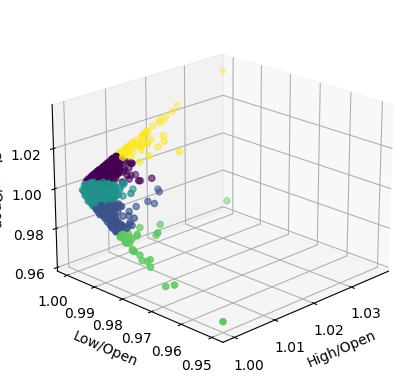

In [23]:
# Plot the 3D normalised candles using H/O, L/O, C/O
if __name__ == "__main__":
    plot_3d_normalised_candles(sp500_norm)

The figure below is a three-dimensional plot of High/Open, Low/Open and Close/Open plotted against each other. Each of the  clusters has been coloured. It is clear the the majority of the bars are located around. This makes sense as most days are not hugely volatile and hence the prices do not trade in too large a range.
#

However, there are many days when the closing price is substantially above the opening price as is evidenced by the light yellow cluster in the top of the figure. In addition, there are many days when the low point is substantially below the opening price, indicated by the light green cluster:

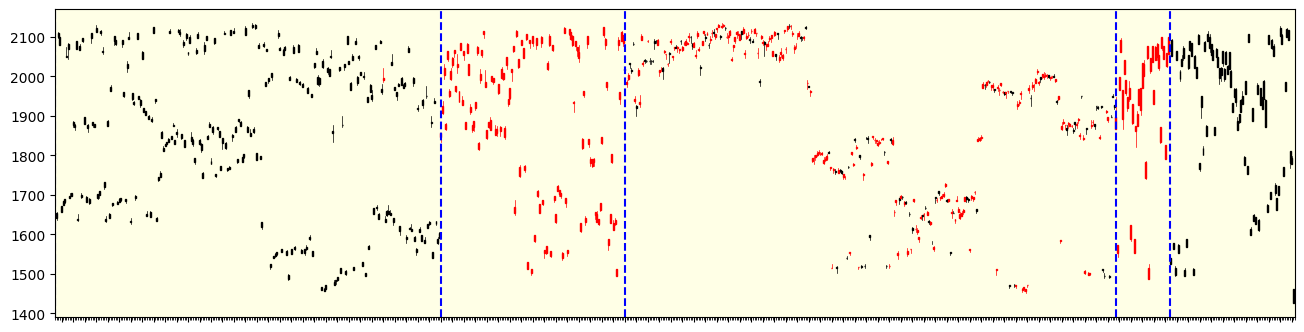

In [24]:
# Plot the full OHLC candles re-ordered 
# into their respective clusters
if __name__ == "__main__":
    plot_cluster_ordered_candles(sp500)

In [25]:
#TESTING
#Checking how plot_cluster_ordered_candles(sp500) works
# data = sp500
# df500 = copy.deepcopy(data)
# df500.sort_values(by="Cluster", inplace=True)
# df500.reset_index(inplace=True)
# df500["clust_index"] = df500.index
# df500["clust_change"] = df500["Cluster"].diff()
# change_indices = df500[df500["clust_change"] != 0]
# change_indices

In [27]:
# Create and output the cluster follow-on matrix
if __name__ == "__main__":
    cust_mat = create_follow_cluster_matrix(sp500)
cust_mat

array([[ 9.15119363,  4.37665782, 14.45623342,  1.06100796,  2.12201592],
       [ 4.77453581,  2.65251989,  3.71352785,  1.06100796,  2.5198939 ],
       [12.86472149,  5.83554377, 16.57824934,  1.06100796,  3.31564987],
       [ 1.85676393,  0.66312997,  0.53050398,  0.53050398,  0.79575597],
       [ 2.5198939 ,  1.32625995,  4.37665782,  0.66312997,  1.19363395]])




### Interpretation
Each element of the matrix represents the percentage frequency of cluster j being the daily follow-on cluster to cluster i. Here's how to interpret the matrix:

Let's assume you have k clusters. Each row in the matrix corresponds to a source cluster (cluster i), and each column corresponds to a follow-on cluster (cluster j). The value in each matrix cell represents the percentage frequency of transitioning from cluster i to cluster j.

For example, let's take the element at row 0 and column 2. This corresponds to transitioning from cluster 0 to cluster 2. The value 14.47543161 indicates that approximately 14.48% of the time, the next day's cluster is cluster 2 given that the current day's cluster is cluster 0.

Similarly, the element at row 3 and column 4 corresponds to transitioning from cluster 3 to cluster 4, with a value of 0.79681275, which means that around 0.80% of the time, the next day's cluster is cluster 4 when the current day's cluster is cluster 3.


#### But my doubt is if they are percentages, then shouldn't each row add up to 100?
It can be seen that this is certainly not an evenly distributed matrix. That is, certain "candles" are likely to follow others with more frequency. This motivates the possibility of forming trading strategies around cluster identification and prediction of subsequent clusters.

### It actually adds up to 100, but not row-wise, but if you sum all the elements

In [28]:
#TESTING
# Let's check if we add all the elements, if it sums up to 100
tot = 0
for i in range(5):
    for j in range(5):
        tot += cust_mat[i][j]
print(tot)

100.0


#

## Notes:


This project is quite different from normal ones where we take say 5 stocks of OHLC data, normalize it, and call k-means. And it will cluster all tech stocks and energy stocks etc. 

Here, we take one stock(S&P 500) and then we cluster OHLC data of each date, so a few days can be in cluster 0 and another few in cluster 3, etc. Going further, we also find the probability/frequency of today's OHLC price going from one cluster to another cluster. 

So, if we are able to recognize the commonalities of each cluster, say one cluster has days where the stock was very volatile and another day it was very calm(O,C,H,L are all very close), from the __cluster follow-on matrix__ we can predict how possible the clam stock today might be more volatile the next day.

- This application can work on any stock/commodity provided Yahoo has the data for it.

- More involvement can be done to fix the value of k, here we have assumed the value of __k = 5__, but if we use the _Elbow Curve Method_, that is we can perform the clustering with many different k and then plot with the Within-cluster sum of squares(WSS), we can find the optimal k.

- Another problem is that all of this work is in-sample. Any future usage of this as a predictive tool implicitly assumes that the distribution of clusters would remain similar to the past. A more realistic implementation would consider some form of "rolling" or "online" clustering tool that would produce a follow-on matrix for each rolling window.

- We can also use evaluation metrics on the clustering multiple times, find the best one and set the random state as the following observation for more optimal and stable results. 

